<a href="https://colab.research.google.com/github/lefth-nd/ml-expert-potato/blob/main/Assignment01_schu0527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP2712_8715 Assignment01: Classifying Images Using MLP and SVM Algorithms 
This assignment is to explore the concepts covered in the topic so far with respect to training and evaluating classifiers such as the Multi-layer Perceptron (MLP) and Support Vector Machines (SVM).  




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# uncomment the below to mount the google drive
#from google.colab import drive
#drive.mount('/content/drive')

## Functions to work with CIFAR

The functions below help with access to the CIFAR-10 data the you have downloaded.

In [3]:
import pickle
import numpy as np
import pandas as pd

def load_CIFAR_batch(filename, flatten=True, categorical=True):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']        
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        if (flatten):
          X = X.reshape(10000, 3072)
        X = X.astype('float32')
        X /= 255

        y = datadict[b'labels']
        y = np.array(y)
        if (categorical):
          y = pd.get_dummies(y).values

        return X, y

def load_CIFAR_meta(filename):
  with open(filename,'rb') as f:
    metadict = pickle.load(f, encoding='bytes')

    class_labels = [ val.decode() for val in metadict.get(b'label_names') ]
    return class_labels

def get_image(X, index, nchans=3, size=32):
  xi = X[index,:]
  img = xi.reshape(32, 32, 3)
  return img

## Load the CIFAR data

The CIFAR data has 5 batches of data and 1 test data set. Each batch is labelled
- `data_batch_1`
- `data_batch_2`
- `data_batch_3`
- `data_batch_4`
- `data_batch_5`

and a test set labelled
- `test_batch`

each batch has 10,000 images, so 50,000 training and 10,000 test images.

Below is example of loading the first batch of training data labelled as `data_batch_1`.  You will need to update the path to match where you have stored your cifar-10 data.

In [4]:
##X, y = load_CIFAR_batch('/content/drive/My Drive/COMP2712/data/cifar-10-batches-py/data_batch_1')

In [5]:
X, y = load_CIFAR_batch('/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1')

In [6]:
batch_1 = '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1'

In [7]:
batch_2 = '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_2'

In [8]:
meta = '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/batches.meta'

The number of instances/examples for all the different classes.  There are 10 different classes.

In [9]:
[np.sum(np.argmax(y, axis=1) == i) for i in range(0,10)]

[1005, 974, 1032, 1016, 999, 937, 1030, 1001, 1025, 981]

In [10]:
ynum = np.sum(np.argmax(y, axis=1))

print(X.shape)

(10000, 3072)


The labels for the classes are stored in the `batches.meta` file

In [11]:
class_labels = load_CIFAR_meta(meta)
print(class_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look at some random cat images, because cats.

In [12]:
import random
import matplotlib.pyplot as plt

def plot_random(X, y, class_labels, what_target='cat'):

  what_label = class_labels.index(what_target)
  what_labeli = np.where(np.argmax(y,axis=1) == what_label)[0]
  random_what_index = what_labeli[random.choice(range(len(what_labeli)))]

  plt.imshow(get_image(X,random_what_index))
  plt.title('{}, index: {}'.format(what_target,random_what_index))
  plt.axis('off')

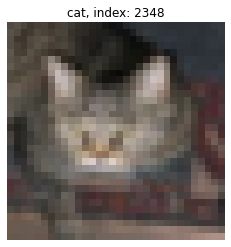

In [13]:
plot_random(X, y, class_labels, what_target='cat')


## Set up and train MLP
printing possible scorers

In [14]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

## Pipeline for Nested CV for MLP

Here we construct a pipeline to scale our data before fitting the mlp and tune the hyperperameters with a param grid. We select the best performing combination of hyperperameters against the scorer.

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# split into train and test

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)


std = StandardScaler()
mlp = MLPClassifier()

pipe = Pipeline([('std', std),('mlp', mlp)])

param_grid = {
    'mlp__solver': ['sgd'],
    'mlp__max_iter': [80],
    'mlp__hidden_layer_sizes': [(1200,)],
    'mlp__activation': ['relu'],
    'mlp__tol': [0.0001],
    'mlp__n_iter_no_change': [20],
    'mlp__early_stopping': [True],
}


search = GridSearchCV(pipe, param_grid, cv=2, verbose=10, scoring='f1_macro', n_jobs=-1)

search.fit(Xtrain, ytrain)

print(search.best_score_)
print(search.best_params_)





Fitting 2 folds for each of 1 candidates, totalling 2 fits
0.3436098679723765
{'mlp__activation': 'relu', 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (1200,), 'mlp__max_iter': 80, 'mlp__n_iter_no_change': 20, 'mlp__solver': 'sgd', 'mlp__tol': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##3D Scatter Plot of Data

[0.7529412  0.24705882 0.30588236 ... 0.02745098 0.9764706  0.49019608]
(2500,)


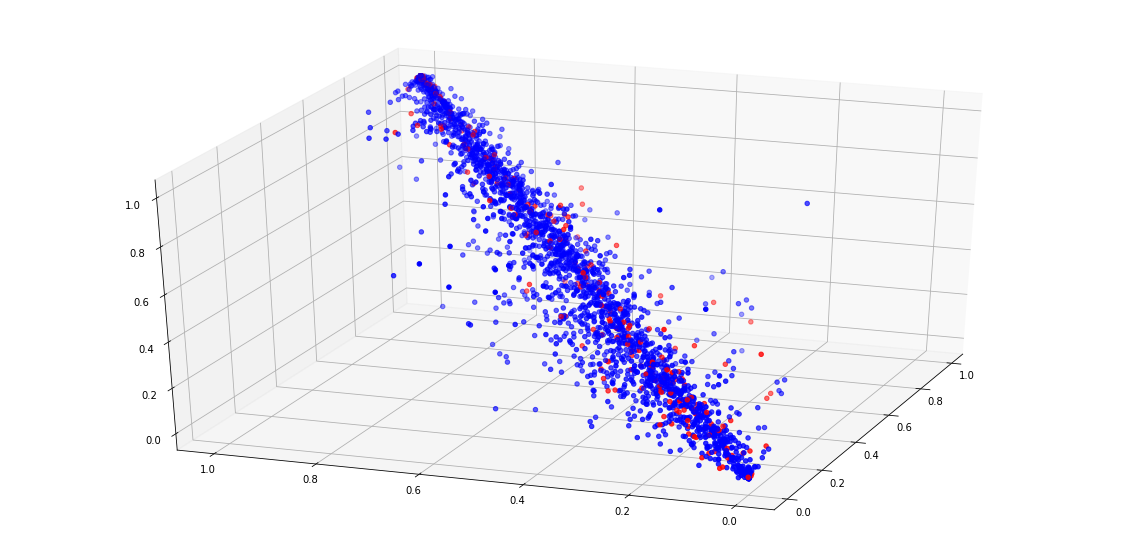

In [16]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20, 10))

ax = plt.axes(projection ="3d")

x1 = Xtest[:,0]
x2 = Xtest[:,1]
x3 = Xtest[:,2]
print(x1)
print(x2.shape)

color = ['red' if value == 1 else 'blue' for value in ytest[:,1]]
ax.scatter3D(x1, x2, x3, color=color)
ax.azim = 200
ax.elev = 30
plt.show()

## Evaluate the performance of the classfier



Here we evalaute using preda and select the max probability.

### Test it out on a random image from the training/testing data.  

Image Index:  2113
Probability of class: [12  0  9  8  0  9  2  5  0  5]
real class     :  5 => dog
predicted class:  0 => airplane


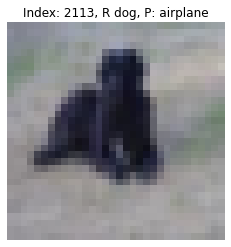

In [17]:
idx = random.choice(range(Xtest.shape[0]))
print('Image Index: ',idx)


ypreda = search.predict_proba(Xtest)
print('Probability of class: {}'.format((ypreda[idx,:]*100).astype(int)))
ypred = np.argmax(ypreda[idx,:], axis=0)
ytrue = np.argmax(ytest[idx,:], axis=0)
print('real class     : ',ytrue,'=>',class_labels[ytrue])
print('predicted class: ',ypred,'=>',class_labels[ypred])

#print result
plt.imshow(get_image(Xtest,idx))
plt.title('Index: {}, R {}, P: {}'.format(idx,class_labels[ytrue],class_labels[ypred]))
plt.axis('off');


### Evaluate the performance on the whole training set

In [18]:
ytrue = np.argmax(ytrain, axis=1)
ypreda = search.predict_proba(Xtrain)
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)


              precision    recall  f1-score   support

           0       0.86      0.92      0.89       754
           1       0.93      0.92      0.93       730
           2       0.88      0.86      0.87       774
           3       0.87      0.86      0.87       762
           4       0.87      0.88      0.88       749
           5       0.92      0.86      0.89       703
           6       0.88      0.91      0.89       772
           7       0.92      0.93      0.92       751
           8       0.91      0.91      0.91       769
           9       0.92      0.92      0.92       736

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500

[[692   9   9   3   7   0   5   8  17   4]
 [ 10 672   3   6   4   1   5   2   8  19]
 [ 20   7 669  12  20  10  16  11   4   5]
 [  6   5  21 655  15  15  23   8   6   8]
 [ 12   5  20   9 658   7  17  12   6   3]
 [  5   3   8  38  14 603 

### Evaluate on the performance on testing set

In [19]:
ytrue = np.argmax(ytest, axis=1)
ypreda = search.predict_proba(Xtest)
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)


              precision    recall  f1-score   support

           0       0.48      0.52      0.50       251
           1       0.51      0.59      0.55       244
           2       0.38      0.33      0.35       258
           3       0.35      0.36      0.36       254
           4       0.37      0.34      0.35       250
           5       0.32      0.33      0.33       234
           6       0.48      0.47      0.48       258
           7       0.50      0.55      0.52       250
           8       0.58      0.59      0.58       256
           9       0.50      0.42      0.45       245

    accuracy                           0.45      2500
   macro avg       0.45      0.45      0.45      2500
weighted avg       0.45      0.45      0.45      2500

[[131  17  15   6   7   8   5   8  38  16]
 [  9 145   6   7   8   3   8  12  17  29]
 [ 31   6  85  15  29  29  19  26  11   7]
 [  6  11  17  91  19  51  29  19   6   5]
 [ 16   7  36  15  85  17  31  29   6   8]
 [  9   8  22  56  17  77 

## Printing a confusion matrix heatmap

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()

print(classification_report(ytrue,ypred))
acc = accuracy_score(ytrue,ypred)

f1 = f1_score(ytrue,ypred)


mat = confusion_matrix(ytrue, ypred)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            ax=ax)
plt.title('Accuracy: {:.2f}, F1: {:.3f}'.format(acc*100,f1))
plt.ylabel('actual label')
plt.xlabel('predicted label');

# 10x10 Cross-Validation

Validate the Multilayer Perceptron Classifier

In [21]:
n_outer =  2
n_splits = 2
acc_outer_mlp = []
f1_outer_mlp  = []
mcc_outer_mlp  = []
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

import tensorflow as tf

filename = '/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1'
with open(filename, 'rb') as f:
  datadict = pickle.load(f, encoding='bytes')
  y = datadict[b'labels']

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(X, y)

  # create a pipeline classifier model based on the best parameters
  model = clone(search.best_estimator_)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)
  

  

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat_mlp = confusion_matrix(y_shuf, y_pred)

  acc_outer_mlp.append(acc)
  f1_outer_mlp.append(f1)
  mcc_outer_mlp.append(mcc)

# report the results
print('MLP Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_mlp)*100,np.std(acc_outer_mlp)*100))
print('MLP Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_mlp),np.std(f1_outer_mlp)))
print('MLP Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_mlp),np.std(mcc_outer_mlp)))

#### Outer Iteration 1 of 2
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


#### Outer Iteration 2 of 2
***** cross_val_predict
MLP Outer accuracy M = 42.19, SD = 0.0600
MLP Outer F1-Score M = 0.420, SD = 0.0009
MLP Outer MCC      M = 0.358, SD = 0.0007


## Implementing the Support Vector Machine

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, make_scorer

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)


std = StandardScaler()
pca = PCA()
svc = SVC()
pipe = Pipeline([('std',std),('pca', pca),('svc',svc)])


param_grid = {
  'pca__n_components': [500],
  'svc__kernel': ['rbf'],
  'svc__C': [100]
}

scoring = 'f1_macro' 



search = GridSearchCV(pipe, param_grid, cv=2, verbose=10, refit=True, scoring=scoring)
search.fit(X_train, y_train)

print()
print('Best parameter CV score={:0.3f}:'.format(search.best_score_))
print(search.best_params_)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START pca__n_components=500, svc__C=100, svc__kernel=rbf..........
[CV 1/2; 1/1] END pca__n_components=500, svc__C=100, svc__kernel=rbf;, score=0.425 total time=  15.9s
[CV 2/2; 1/1] START pca__n_components=500, svc__C=100, svc__kernel=rbf..........
[CV 2/2; 1/1] END pca__n_components=500, svc__C=100, svc__kernel=rbf;, score=0.425 total time=  16.2s

Best parameter CV score=0.425:
{'pca__n_components': 500, 'svc__C': 100, 'svc__kernel': 'rbf'}


## Evaluate on Test Set

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

In [25]:

ypred = search.predict(X_test)
report = classification_report(y_test, ypred)
print(accuracy_score(y_test, ypred))
print(report)

mat = confusion_matrix(y_test,ypred)
print(mat)

0.4684
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       251
           1       0.56      0.61      0.58       244
           2       0.34      0.34      0.34       258
           3       0.28      0.32      0.30       254
           4       0.38      0.35      0.37       250
           5       0.37      0.36      0.37       234
           6       0.56      0.48      0.52       258
           7       0.54      0.51      0.52       250
           8       0.61      0.58      0.59       256
           9       0.57      0.55      0.56       245

    accuracy                           0.47      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.47      0.47      0.47      2500

[[142  12  20   8   8   5   2   7  32  15]
 [ 11 149   6  13   7   4   4   8  14  28]
 [ 27   9  89  33  27  29  20  14   5   5]
 [ 11  10  17  82  24  49  22  19   6  14]
 [ 19   4  49  20  88  14  19  21  10   6]
 [  7   9  18  59  

## Heatmap for SVM

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       251
           1       0.56      0.61      0.58       244
           2       0.34      0.34      0.34       258
           3       0.28      0.32      0.30       254
           4       0.38      0.35      0.37       250
           5       0.37      0.36      0.37       234
           6       0.56      0.48      0.52       258
           7       0.54      0.51      0.52       250
           8       0.61      0.58      0.59       256
           9       0.57      0.55      0.56       245

    accuracy                           0.47      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.47      0.47      0.47      2500



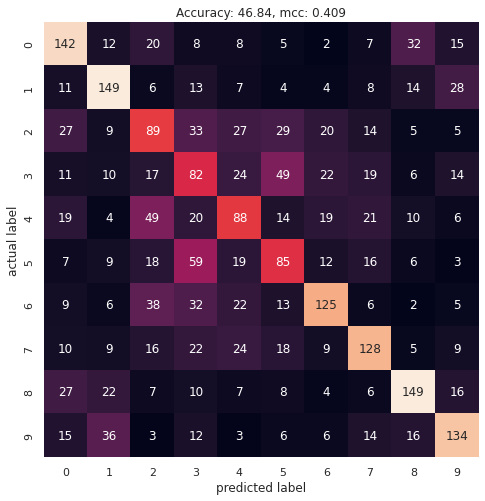

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()

print(classification_report(y_test,ypred))
acc = accuracy_score(y_test,ypred)


mcc = matthews_corrcoef(y_test,ypred)

mat = confusion_matrix(y_test, ypred)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            ax=ax)
plt.title('Accuracy: {:.2f}, mcc: {:.3f}'.format(acc*100,mcc))
plt.ylabel('actual label')
plt.xlabel('predicted label');

Image Index:  1124
Probability of class: 800
8
real class     :  8 => ship
predicted class:  8 => ship
Image Index:  2483
Probability of class: 500
5
real class     :  5 => dog
predicted class:  5 => dog
Image Index:  1809
Probability of class: 200
2
real class     :  2 => bird
predicted class:  2 => bird
Image Index:  1868
Probability of class: 900
9
real class     :  9 => truck
predicted class:  9 => truck
Image Index:  974
Probability of class: 800
8
real class     :  8 => ship
predicted class:  8 => ship
Image Index:  55
Probability of class: 400
4
real class     :  4 => deer
predicted class:  4 => deer
Image Index:  193
Probability of class: 700
7
real class     :  7 => horse
predicted class:  7 => horse
Image Index:  976
Probability of class: 200
2
real class     :  2 => bird
predicted class:  2 => bird
Image Index:  1676
Probability of class: 100
1
real class     :  1 => automobile
predicted class:  1 => automobile
Image Index:  1708
Probability of class: 800
8
real class     : 

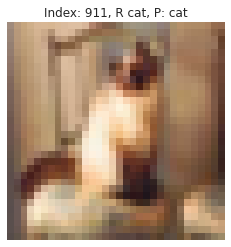

In [27]:

count = 0

for i in range(30):
  idx = random.choice(range(Xtest.shape[0]))
  print('Image Index: ',idx)
  # make sure you use predict_proba for the multi-class classification
  ypred = search.predict(Xtest)
  print('Probability of class: {}'.format((ypred[idx]*100).astype(int)))
  print(ypred[idx])
  ypred = ypred[idx]
  ytrue = np.argmax(ytest[idx], axis=0)
  print('real class     : ',ytrue,'=>',class_labels[ytrue])
  print('predicted class: ',ypred,'=>',class_labels[ypred])

  #print result
  plt.imshow(get_image(Xtest,idx))
  plt.title('Index: {}, R {}, P: {}'.format(idx,class_labels[ytrue],class_labels[ypred]))
  plt.axis('off');
  if(ytrue == ypred): count = count + 1

print("True Positives:", count)

## 10x10 Cross Validation for SVM

In [28]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

n_outer =  2 # this should be 10 for the "10"x 10 CV, you could use a smaller values, say 2, for prototyping
n_splits = 2 # this should be 10 for the 10 x "10" CV, you could use a smaller values, say 2, for prototyping
acc_outer_svm = []
f1_outer_svm  = []
mcc_outer_svm  = []

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(X, y)

  # create a pipeline classifier model based on the best parameters
  model = clone(search.best_estimator_)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat_svm = confusion_matrix(y_shuf, y_pred)

  acc_outer_svm.append(acc)
  f1_outer_svm.append(f1)
  mcc_outer_svm.append(mcc)

print('SVM Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_svm)*100,np.std(acc_outer_svm)*100))
print('SVM Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_svm),np.std(f1_outer_svm)))
print('SVM Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_svm),np.std(mcc_outer_svm)))

#### Outer Iteration 1 of 2
***** cross_val_predict
#### Outer Iteration 2 of 2
***** cross_val_predict
SVM Outer accuracy M = 44.56, SD = 0.1300
SVM Outer F1-Score M = 0.446, SD = 0.0012
SVM Outer MCC      M = 0.384, SD = 0.0014


## Compare Models with T Statistic

In [29]:
from scipy import stats
stats.ttest_ind(f1_outer_svm, f1_outer_mlp)

Ttest_indResult(statistic=17.800861891358085, pvalue=0.0031410004763958326)